<a href="https://colab.research.google.com/github/rhythmgoyal11/dual_momentum/blob/main/NIFTY_GOLD_dual_momentum_10yr_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for NIFTYBEES and GOLDBEES...


/tmp/ipython-input-2141428452.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE)
[*********************100%***********************]  2 of 2 completed


Starting Backtest with 100000 INR...


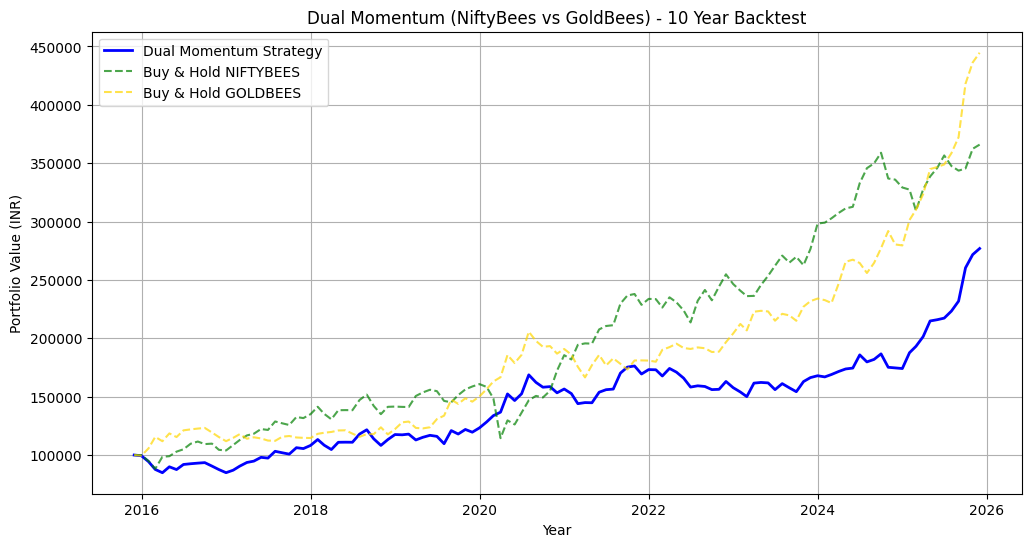

Final Portfolio Values (Initial: 100000):
Strategy:       276,877.00 (CAGR: 10.72%)
NIFTYBEES Only: 365,880.24 (CAGR: 13.85%)
GOLDBEES Only:  444,584.62 (CAGR: 16.09%)


In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


INITIAL_CAPITAL = 100000
START_DATE = "2014-11-01"  # 10 Years ago (+ 1 year buffer for 12m lookback)
END_DATE = "2025-11-18"

# Transaction Charges (As decimals)
NIFTY_BUY_CHARGE = 0.0001862  # 0.01862%
NIFTY_SELL_CHARGE = 0.0000462 # 0.00462%
GOLD_BUY_CHARGE = 0.0001862   # 0.01862%
GOLD_SELL_CHARGE = 0.0000362  # 0.00362%

print("Fetching data for NIFTYBEES and GOLDBEES...")
tickers = ['NIFTYBEES.NS', 'GOLDBEES.NS']
data = yf.download(tickers, start=START_DATE, end=END_DATE)


data = data.xs('Close', level=0, axis=1)

# Drop missing data and resample to Month End
monthly_data = data.resample('ME').last().dropna()

# STRATEGY LOGIC
# Calculate 12-month Momentum (Price Return) excluding the most recent month
# This means, for month T, we calculate the return from T-12 to T-1
momentum_lookback = 12
prices_at_t_minus_1 = monthly_data.shift(1)
prices_at_t_minus_12 = monthly_data.shift(momentum_lookback)
monthly_returns = (prices_at_t_minus_1 / prices_at_t_minus_12) - 1


strategy_df = monthly_data.iloc[momentum_lookback:]
momentum_df = monthly_returns.iloc[momentum_lookback:]

portfolio_value = INITIAL_CAPITAL
current_holding = None  # 'NIFTYBEES' or 'GOLDBEES' or None
equity_curve = []
dates = []

print(f"Starting Backtest with {INITIAL_CAPITAL} INR...")

for date, row in strategy_df.iterrows():
    nifty_price = row['NIFTYBEES.NS']
    gold_price = row['GOLDBEES.NS']

    nifty_mom = momentum_df.loc[date, 'NIFTYBEES.NS']
    gold_mom = momentum_df.loc[date, 'GOLDBEES.NS']

    # Decision Logic: Buy the one with greater 12-month return
    target_asset = 'NIFTYBEES' if nifty_mom > gold_mom else 'GOLDBEES'

    # Execution Logic
    if current_holding is None:
        # First Trade
        if target_asset == 'NIFTYBEES':
            units = (portfolio_value * (1 - NIFTY_BUY_CHARGE)) / nifty_price
            current_holding = 'NIFTYBEES'
        else:
            units = (portfolio_value * (1 - GOLD_BUY_CHARGE)) / gold_price
            current_holding = 'GOLDBEES'

    elif current_holding != target_asset:
        # REBALANCE: Sell current -> Buy target
        if current_holding == 'NIFTYBEES':
            # Sell Nifty
            sell_value = units * nifty_price
            net_cash = sell_value * (1 - NIFTY_SELL_CHARGE)
            # Buy Gold
            units = (net_cash * (1 - GOLD_BUY_CHARGE)) / gold_price
            current_holding = 'GOLDBEES'
        else:
            # Sell Gold
            sell_value = units * gold_price
            net_cash = sell_value * (1 - GOLD_SELL_CHARGE)
            # Buy Nifty
            units = (net_cash * (1 - NIFTY_BUY_CHARGE)) / nifty_price
            current_holding = 'NIFTYBEES'

    # Update Portfolio Value for the month
    if current_holding == 'NIFTYBEES':
        current_value = units * nifty_price
    else:
        current_value = units * gold_price

    equity_curve.append(current_value)
    dates.append(date)

# BENCHMARK COMPARISON
# Buy & Hold NiftyBees
nifty_start_price = strategy_df['NIFTYBEES.NS'].iloc[0]
nifty_units = (INITIAL_CAPITAL * (1 - NIFTY_BUY_CHARGE)) / nifty_start_price
nifty_bnh = strategy_df['NIFTYBEES.NS'] * nifty_units

# Buy & Hold GoldBees
gold_start_price = strategy_df['GOLDBEES.NS'].iloc[0]
gold_units = (INITIAL_CAPITAL * (1 - GOLD_BUY_CHARGE)) / gold_start_price
gold_bnh = strategy_df['GOLDBEES.NS'] * gold_units

# VISUALIZATION
results_df = pd.DataFrame({
    'Dual Momentum': equity_curve,
    'Buy & Hold NIFTYBEES': nifty_bnh.values,
    'Buy & Hold GOLDBEES': gold_bnh.values
}, index=dates)

plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Dual Momentum'], label='Dual Momentum Strategy', linewidth=2, color='blue')
plt.plot(results_df.index, results_df['Buy & Hold NIFTYBEES'], label='Buy & Hold NIFTYBEES', linestyle='--', color='green', alpha=0.7)
plt.plot(results_df.index, results_df['Buy & Hold GOLDBEES'], label='Buy & Hold GOLDBEES', linestyle='--', color='gold', alpha=0.7)

plt.title('Dual Momentum (NiftyBees vs GoldBees) - 10 Year Backtest')
plt.ylabel('Portfolio Value (INR)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

# PRINT FINAL STATS
final_val_strat = results_df['Dual Momentum'].iloc[-1]
final_val_nifty = results_df['Buy & Hold NIFTYBEES'].iloc[-1]
final_val_gold = results_df['Buy & Hold GOLDBEES'].iloc[-1]

print(f"Final Portfolio Values (Initial: {INITIAL_CAPITAL}):")
print(f"Strategy:       {final_val_strat:,.2f} (CAGR: {((final_val_strat/INITIAL_CAPITAL)**(1/10)-1)*100:.2f}%)")
print(f"NIFTYBEES Only: {final_val_nifty:,.2f} (CAGR: {((final_val_nifty/INITIAL_CAPITAL)**(1/10)-1)*100:.2f}%)")
print(f"GOLDBEES Only:  {final_val_gold:,.2f} (CAGR: {((final_val_gold/INITIAL_CAPITAL)**(1/10)-1)*100:.2f}%)")

In [2]:
monthly_returns_strat = results_df['Dual Momentum'].pct_change().dropna()
monthly_returns_nifty = results_df['Buy & Hold NIFTYBEES'].pct_change().dropna()
monthly_returns_gold = results_df['Buy & Hold GOLDBEES'].pct_change().dropna()

# Assume an annual risk-free rate of 5%
annual_risk_free_rate = 0.05
monthly_risk_free_rate = (1 + annual_risk_free_rate)**(1/12) - 1

# Calculate Sharpe Ratios
sharpe_ratio_strat = (monthly_returns_strat.mean() - monthly_risk_free_rate) / monthly_returns_strat.std() * (12**0.5)
sharpe_ratio_nifty = (monthly_returns_nifty.mean() - monthly_risk_free_rate) / monthly_returns_nifty.std() * (12**0.5)
sharpe_ratio_gold = (monthly_returns_gold.mean() - monthly_risk_free_rate) / monthly_returns_gold.std() * (12**0.5)

print(f"Sharpe Ratio (Dual Momentum): {sharpe_ratio_strat:.2f}")
print(f"Sharpe Ratio (Buy & Hold NIFTYBEES): {sharpe_ratio_nifty:.2f}")
print(f"Sharpe Ratio (Buy & Hold GOLDBEES): {sharpe_ratio_gold:.2f}")

Sharpe Ratio (Dual Momentum): 0.46
Sharpe Ratio (Buy & Hold NIFTYBEES): 0.60
Sharpe Ratio (Buy & Hold GOLDBEES): 0.84


In [3]:
def calculate_max_drawdown(equity_curve):
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (equity_curve - peak) / peak
    return drawdown.min()

max_drawdown_strat = calculate_max_drawdown(results_df['Dual Momentum'])
max_drawdown_nifty = calculate_max_drawdown(results_df['Buy & Hold NIFTYBEES'])
max_drawdown_gold = calculate_max_drawdown(results_df['Buy & Hold GOLDBEES'])

print(f"Maximum Drawdown (Dual Momentum): {max_drawdown_strat:.2%}")
print(f"Maximum Drawdown (Buy & Hold NIFTYBEES): {max_drawdown_nifty:.2%}")
print(f"Maximum Drawdown (Buy & Hold GOLDBEES): {max_drawdown_gold:.2%}")

Maximum Drawdown (Dual Momentum): -15.15%
Maximum Drawdown (Buy & Hold NIFTYBEES): -28.81%
Maximum Drawdown (Buy & Hold GOLDBEES): -19.03%
